In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data.sampler import SubsetRandomSampler

import os
import h5py
import matplotlib.pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
device = 'cuda'
from time import time

import losses
from utils import ScatteringProblemForward
from visualizations import plot_outcomes_identified, describe_false_shapes, describe_positive_shapes

In [14]:
filename_out    = 'output/ff_nn.pt'
# Model to load and continue training. Ignored if empty string
filename_in     = ''
# Compute device to perform the training on, 'cuda' or 'cpu'
device          = 'cuda'
# Use interactive visualization of losses and other plots. Requires visdom
interactive_visualization = False # check first how this visdom works
# Run a list of python functions at test time after eacch epoch
# See toy_modes_train.py for reference example
test_time_functions = []

#######################
#  Training schedule  #
#######################

# Initial learning rate
lr_init         = 1.0e-2
#Batch size
batch_size      = 128
# Total number of epochs to train for
n_epochs        = 80

# End the epoch after this many iterations (or when the train loader is exhausted)
n_its_per_epoch = 200
# For the first n epochs, train with a much lower learning rate. This can be
# helpful if the model immediately explodes.
pre_low_lr      = 0
# Decay exponentially each epoch, to final_decay*lr_init at the last epoch.
final_decay     = 0.02
# L2 weight regularization of model parameters
l2_weight_reg   = 1e-5
# Parameters beta1, beta2 of the Adam optimizer
adam_betas = (0.9, 0.95)

#####################
#  Data dimensions  #
#####################
ndim_x_class     = 3
ndim_x_features     = 7

ndim_y     = 512

# Overwrite or import data loaders here.
# See dkfz_train.py for reference.
#from my_loaders import train_loader, test_loader

train_loader, test_loader = None, None


############
#  Losses  #
############

train_forward_mmd    = True

lambd_mmd_for_class    = 10
lambd_mmd_for_feature  = 100

# Both for fitting, and for the reconstruction, perturb y with Gaussian 
# noise of this sigma
add_y_noise     = 0 # think of smth smart here
# For reconstruction, perturb z 
add_z_noise     = 2e-2
# In all cases, perturb the zero padding
add_pad_noise   = 1e-2

# For noisy forward processes, the sigma on y (assumed equal in all dimensions).
# This is only used if mmd_back_weighted of train_max_likelihoiod are True.
y_uncertainty_sigma = 0.12 * 4

mmd_forw_kernels = [(0.2, 2), (1.5, 2), (3.0, 2)]
mmd_back_kernels = [(0.2, 0.1), (0.2, 0.5), (0.2, 2)]
mmd_back_weighted = True

###########
#  Model  #
###########

# Initialize the model parameters from a normal distribution with this sigma
init_scale = 0.10
#
N_blocks   = 25
#
exponent_clamping = 2.0
#
hidden_layer_sizes = 1024
#
use_permutation = True
#
verbose_construction = False

In [3]:
lp = ScatteringProblemForward( device,  batch_size, ndim_x_class, ndim_x_features, ndim_y, init_scale, final_decay, n_epochs, lr_init, adam_betas, l2_weight_reg, 
                        lambd_mmd_for_class, lambd_mmd_for_feature, mmd_back_weighted, y_uncertainty_sigma, n_its_per_epoch, pre_low_lr, filename_out, mmd_forw_kernels, mmd_back_kernels)

In [4]:
lp.read_data('/home/slaskina/simulations')

In [7]:

#lp.normalize_labels()

In [15]:
lp.update_hyperparameters( device,  batch_size, ndim_x_class, ndim_x_features, ndim_y, init_scale, final_decay, n_epochs, lr_init, adam_betas, l2_weight_reg, 
                        lambd_mmd_for_class, lambd_mmd_for_feature, mmd_back_weighted, y_uncertainty_sigma, n_its_per_epoch, pre_low_lr, filename_out, mmd_forw_kernels, mmd_back_kernels)

In [16]:
lp.create_loaders()

In [17]:
class ForwardScatteringConvolutional(nn.Module):
    def __init__(self, N_blocks) -> None:
        super().__init__()
        self.N_blocks = N_blocks
        self.sequence_block = nn.Sequential(
            nn.Conv1d(512, 512, kernel_size = 5,padding = 2, stride=1),
            nn.ELU(),
            nn.AvgPool1d(5, padding=2, stride=1),
            #nn.BatchNorm1d(512)
        )
        self.s1 = nn.Sequential(
            nn.Conv1d(in_channels = 512, out_channels = 128 , kernel_size = 11, padding=5, stride=3),
            nn.ELU(),
            #nn.BatchNorm1d(128)
        )
        self.linear_out = nn.Sequential(    
            nn.Linear(128, 10),
            nn.ELU()
        )
        self.flatten = nn.Flatten()
    def forward(self, x):
        x = x.reshape(len(x), -1, 1)
        for _ in range(self.N_blocks):
            x =  self.sequence_block(x)
        x = self.s1(x)
        x = self.flatten(x)
        x = self.linear_out(x)
        return x.reshape(-1,10)
model_simple_conv = ForwardScatteringConvolutional(N_blocks)

In [18]:
lp.set_model(model_simple_conv)
lp.set_optimizer()

In [19]:
lp.train()

Epoch 0: training loss: 82.86197357642942, test loss: 24.062593294226605
Epoch 1: training loss: 25.151831487329996, test loss: 24.333546928737473
Epoch 2: training loss: 24.62180770315775, test loss: 24.391500555950664
Epoch 3: training loss: 24.563637942802615, test loss: 25.05096966287364
Epoch 4: training loss: 25.276661175053295, test loss: 44.73172959037449
Epoch 5: training loss: 33.411081081483424, test loss: 26.443096741386082
Epoch 6: training loss: 25.385516306249105, test loss: 24.49202222409456
Epoch 7: training loss: 28.982235233958175, test loss: 26.545776615972105
Epoch 8: training loss: 25.13968218826666, test loss: 24.456123020337976
Epoch 9: training loss: 24.73646617517239, test loss: 24.509917798249617
Epoch 10: training loss: 25.26270582617783, test loss: 24.29417485776155
Epoch 11: training loss: 24.869333802199947, test loss: 24.54752142533012
Epoch 12: training loss: 24.86436822937756, test loss: 24.38606892461362
Epoch 13: training loss: 24.666284375074433, te

In [20]:
df_train = lp.create_table_from_outcomes(lp.make_prediction(lp.train_indices), lp.train_indices)
df_val = lp.create_table_from_outcomes(lp.make_prediction(lp.val_indices), lp.val_indices) 
df_test = lp.create_table_from_outcomes(lp.make_prediction(lp.test_indices), lp.test_indices)

Accuracy is 28.18%
MSE for radius per shape for correctly identified instances as follows: sphere: 113.8620, hardsphere: 5411.6211 and cylinder: 655.1931
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 67.6670, hardsphere: 1334.5243 and cylinder: 54722572.0000
MSE for cylinder length for correctly identified instances: 230.4109
MSE for cylinder length polydispersity for correctly identified instances: 1.3246
MSE for cylinder length for correctly identified instances: 99004.2266


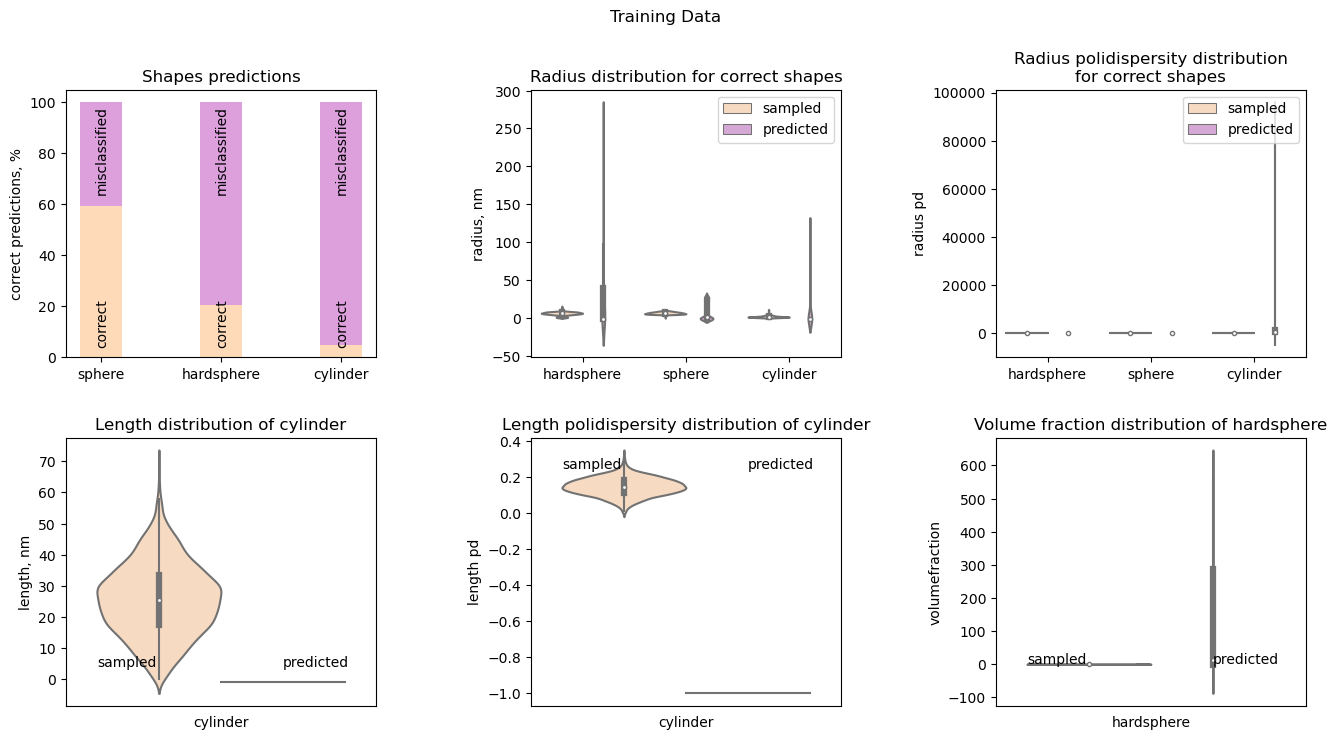

In [21]:
plot_outcomes_identified(df_train, 'Training')

Accuracy is 27.67%
MSE for radius per shape for correctly identified instances as follows: sphere: 108.9104, hardsphere: 5954.4219 and cylinder: 350.5531
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 65.7806, hardsphere: 1268.2524 and cylinder: 2309449.5000
MSE for cylinder length for correctly identified instances: 242.4967
MSE for cylinder length polydispersity for correctly identified instances: 1.3495
MSE for cylinder length for correctly identified instances: 113420.4453


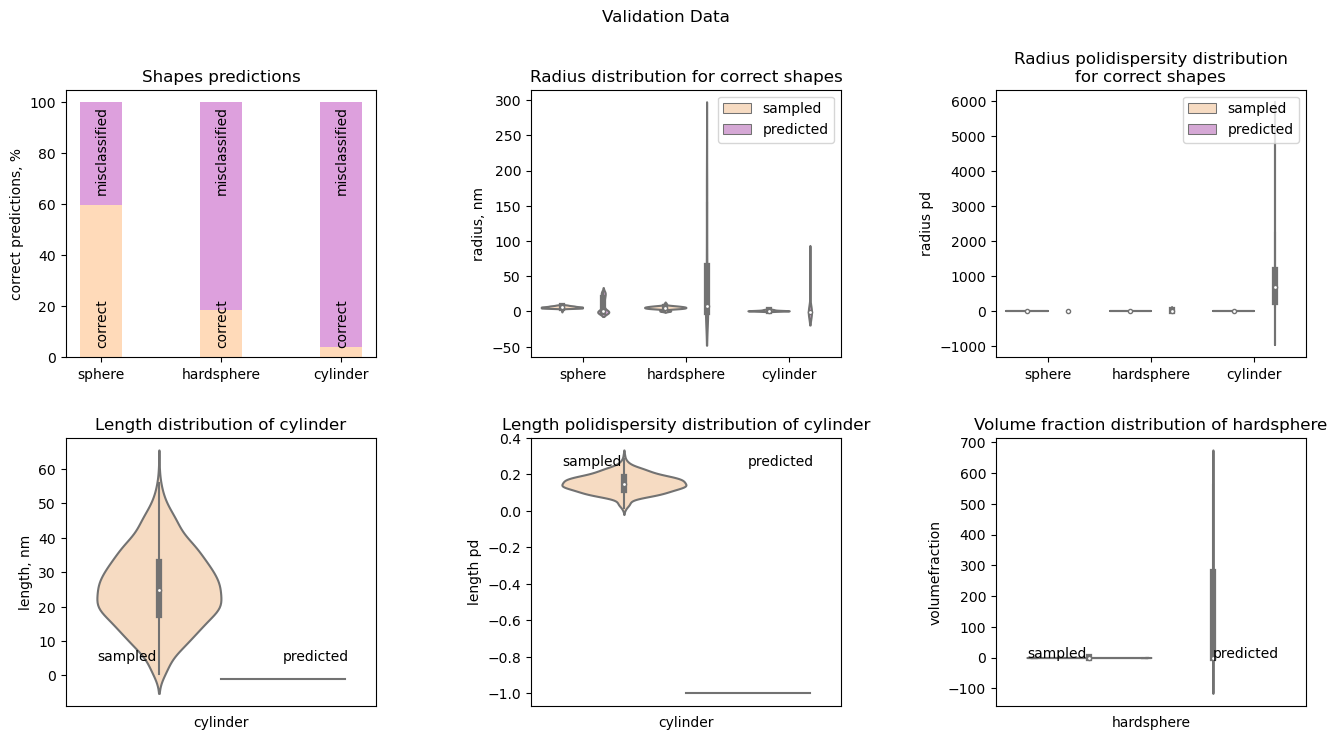

In [22]:
plot_outcomes_identified(df_val, 'Validation')

Accuracy is 26.73%
MSE for radius per shape for correctly identified instances as follows: sphere: 115.6970, hardsphere: 4988.9165 and cylinder: 728.6374
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 77.1728, hardsphere: 1208.7611 and cylinder: 744484.5000
MSE for cylinder length for correctly identified instances: 167.6277
MSE for cylinder length polydispersity for correctly identified instances: 1.3391
MSE for cylinder length for correctly identified instances: 88498.3906


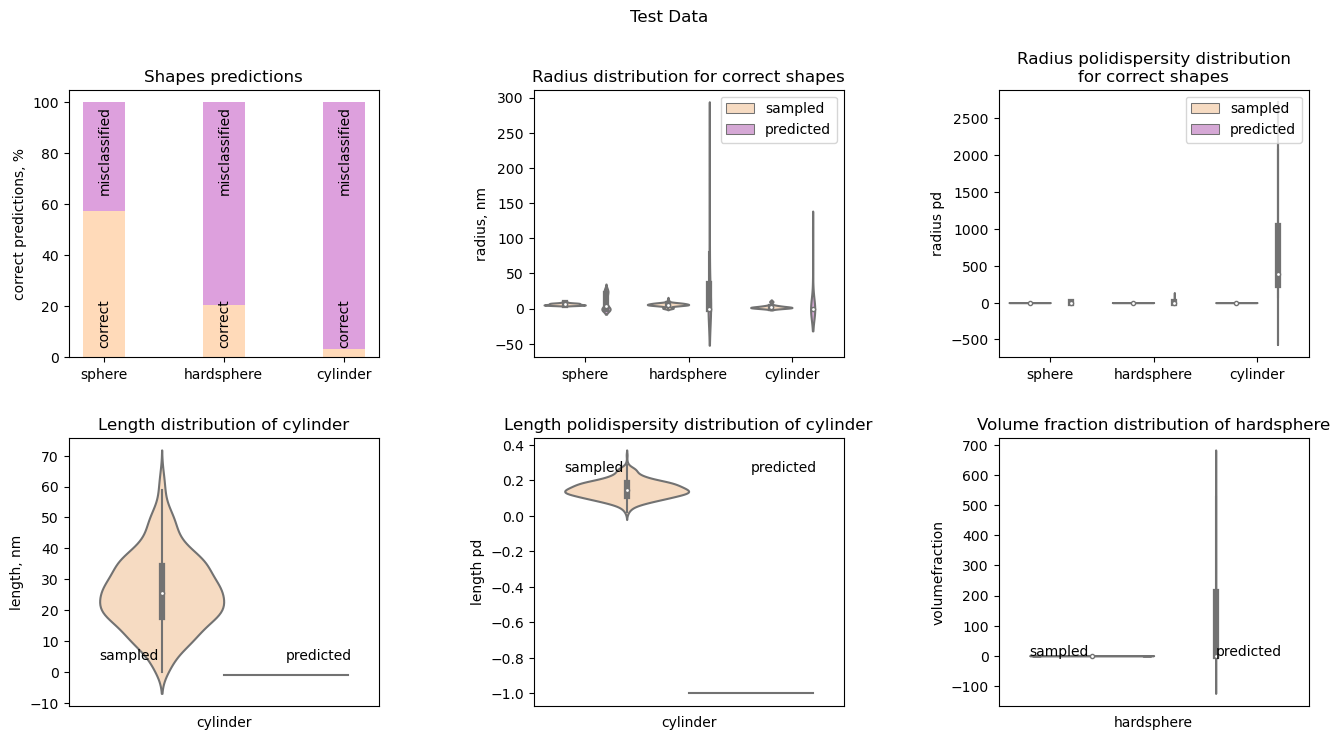

In [23]:
plot_outcomes_identified(df_test, 'Test')